## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO

but Gdown can't. Please check connections and permissions.


In [ ]:
!pip install faiss-cpu

In [ ]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW

but Gdown can't. Please check connections and permissions.


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip


Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.j

In [145]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
import matplotlib.pyplot as plt


In [146]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        # transforms.Normalize(
        #     (0.485, 0.456, 0.406),  # normalize image for pre-trained model
        #     (0.229, 0.224, 0.225),
        # )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [147]:

ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [148]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [149]:
cap_path = '/content/drive/MyDrive/Colab Notebooks/rollnumber_A1/rollnumber_A1_Q2/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [150]:
img_path = '/content/drive/MyDrive/Colab Notebooks/rollnumber_A1/rollnumber_A1_Q2/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [151]:
from nltk.translate.bleu_score import sentence_bleu

def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = sentence_bleu([references], pre)
        accuracy += score
    return accuracy/len(predict)


Number of samples:  40504


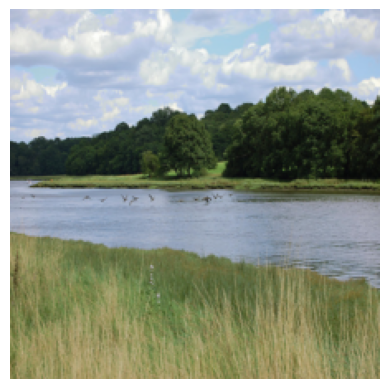

Ground Truth Captions: ['Various birds flying over a body of water next to trees.', 'A placid and meandering river with some large water fowl flying just above it.', 'A serene lake has large water birds flying over it.', 'A group of geese are flying low over a pond.', 'A flock of birds flying over a pond.']
Predicted Caption: A placid and meandering river with some large water fowl flying just above it.
BLEU Score: 1.0
---


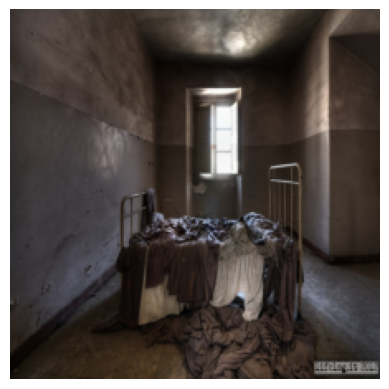

Ground Truth Captions: ['The bed covered in many sheets and blankets is the only furniture in the room.', 'An unmade dirty bed in a filthy room with a window.', 'The old metal bed with dirty linens is the only furnishing in the abandoned room', 'a bed covered in heaps of rags and dirty bedding', 'there is a very large room with only a bed in it']
Predicted Caption: The old metal bed with dirty linens is the only furnishing in the abandoned room
BLEU Score: 1.0
---


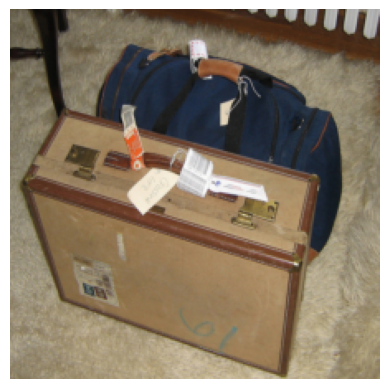

Ground Truth Captions: ['A couple of pieces of luggage sitting on the ground.', 'A duffle bag and a suitcase next to each other.', 'a suitcase sitting next to a duffel bag on the floor ', 'The suitcases are packed and ready to be carried', 'A hard suitcase and blue back with airline tags sit on a rug.']
Predicted Caption: A stack of antique luggage is displayed with price tags.
BLEU Score: 0.5198393658077773
---


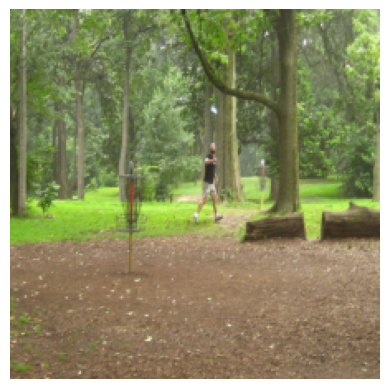

Ground Truth Captions: ['A man wearing shorts is running through the woods playing frisbee golf.', 'A man in black shirt with frisbee in a forest area.', 'A man catching a Frisbee that was thrown to him in a game of Frisbee Golf.', 'A man playing golf frisbee in a wooded park area.', 'a man playing with a Frisbee playing in the park']
Predicted Caption: A man playing golf frisbee in a wooded park area.
BLEU Score: 1.0
---


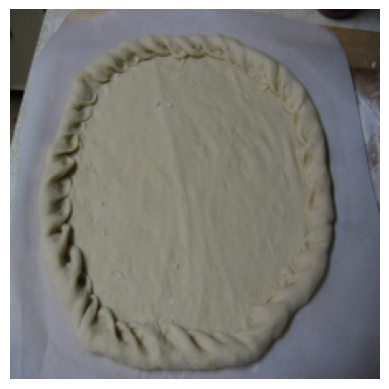

Ground Truth Captions: ['A crimped pie crust is on waxed paper.', 'pizza dough prepped and laid out on a table top ', 'The dough is shaped in a circle on the cloth.', 'a pizza shaped circle of round dough on a white surface', 'A pile of dough shaped into a pizza crust with twirls in it.']
Predicted Caption: A pizza on a sheet of cookie paper being prepared to be baked.
BLEU Score: 0.48981455951423375
---
Average BLEU Score for k=1: 0.8019307850644022
---


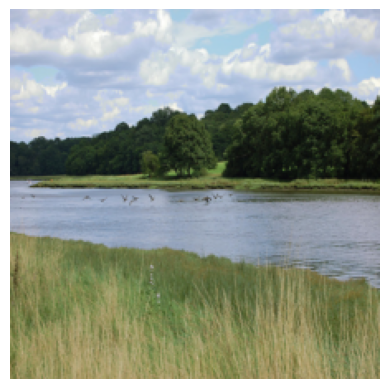

Ground Truth Captions: ['Various birds flying over a body of water next to trees.', 'A placid and meandering river with some large water fowl flying just above it.', 'A serene lake has large water birds flying over it.', 'A group of geese are flying low over a pond.', 'A flock of birds flying over a pond.']
Predicted Caption: Several horses are drinking from the water while others walk on the bank.
BLEU Score: 0.3122111310042659
---


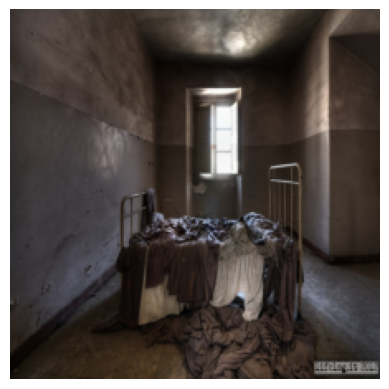

Ground Truth Captions: ['The bed covered in many sheets and blankets is the only furniture in the room.', 'An unmade dirty bed in a filthy room with a window.', 'The old metal bed with dirty linens is the only furnishing in the abandoned room', 'a bed covered in heaps of rags and dirty bedding', 'there is a very large room with only a bed in it']
Predicted Caption: An empty prison cell with a bed and a table.
BLEU Score: 0.4651841341399212
---


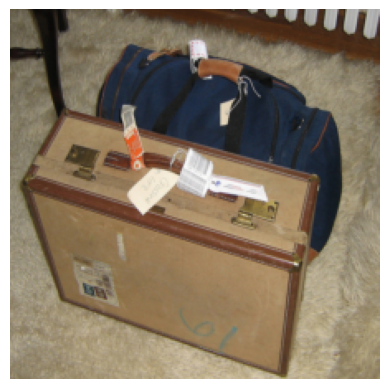

Ground Truth Captions: ['A couple of pieces of luggage sitting on the ground.', 'A duffle bag and a suitcase next to each other.', 'a suitcase sitting next to a duffel bag on the floor ', 'The suitcases are packed and ready to be carried', 'A hard suitcase and blue back with airline tags sit on a rug.']
Predicted Caption: An open suitcase on a bed with items to be packed.
BLEU Score: 0.6808850426634114
---


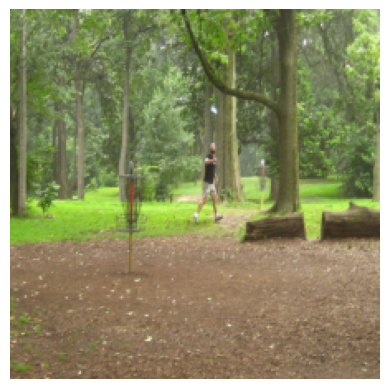

Ground Truth Captions: ['A man wearing shorts is running through the woods playing frisbee golf.', 'A man in black shirt with frisbee in a forest area.', 'A man catching a Frisbee that was thrown to him in a game of Frisbee Golf.', 'A man playing golf frisbee in a wooded park area.', 'a man playing with a Frisbee playing in the park']
Predicted Caption: A man playing golf frisbee in a wooded park area.
BLEU Score: 1.0
---


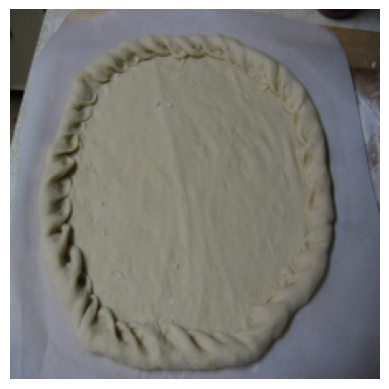

Ground Truth Captions: ['A crimped pie crust is on waxed paper.', 'pizza dough prepped and laid out on a table top ', 'The dough is shaped in a circle on the cloth.', 'a pizza shaped circle of round dough on a white surface', 'A pile of dough shaped into a pizza crust with twirls in it.']
Predicted Caption: a pizza shaped circle of round dough on a white surface
BLEU Score: 1.0
---
Average BLEU Score for k=3: 0.6916560615615197
---


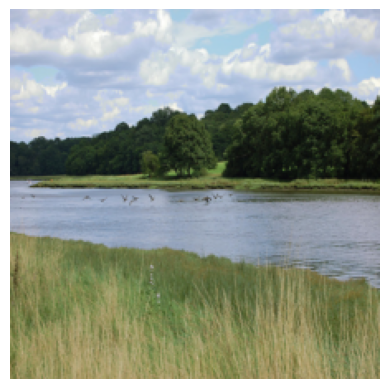

Ground Truth Captions: ['Various birds flying over a body of water next to trees.', 'A placid and meandering river with some large water fowl flying just above it.', 'A serene lake has large water birds flying over it.', 'A group of geese are flying low over a pond.', 'A flock of birds flying over a pond.']
Predicted Caption: Several horses are drinking from the water while others walk on the bank.
BLEU Score: 0.3122111310042659
---


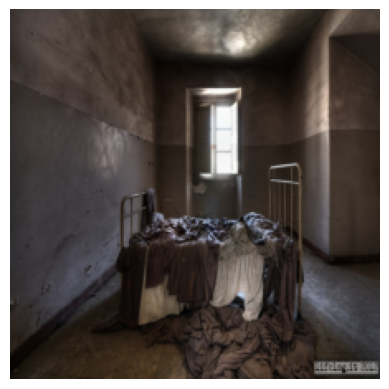

Ground Truth Captions: ['The bed covered in many sheets and blankets is the only furniture in the room.', 'An unmade dirty bed in a filthy room with a window.', 'The old metal bed with dirty linens is the only furnishing in the abandoned room', 'a bed covered in heaps of rags and dirty bedding', 'there is a very large room with only a bed in it']
Predicted Caption: An empty prison cell with a bed and a table.
BLEU Score: 0.4651841341399212
---


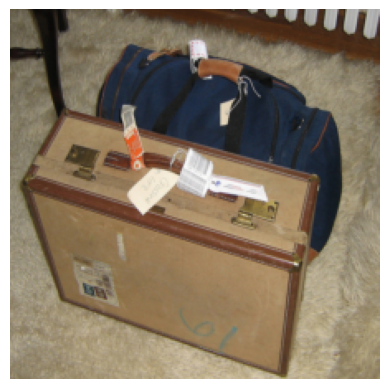

Ground Truth Captions: ['A couple of pieces of luggage sitting on the ground.', 'A duffle bag and a suitcase next to each other.', 'a suitcase sitting next to a duffel bag on the floor ', 'The suitcases are packed and ready to be carried', 'A hard suitcase and blue back with airline tags sit on a rug.']
Predicted Caption: An open suitcase on the floor containing various items.
BLEU Score: 0.555966118963687
---


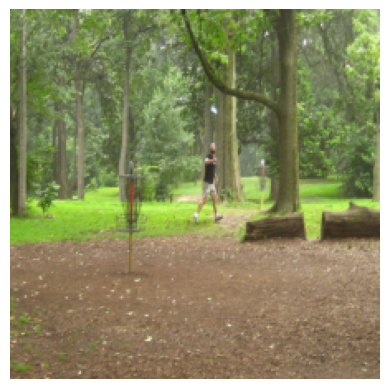

Ground Truth Captions: ['A man wearing shorts is running through the woods playing frisbee golf.', 'A man in black shirt with frisbee in a forest area.', 'A man catching a Frisbee that was thrown to him in a game of Frisbee Golf.', 'A man playing golf frisbee in a wooded park area.', 'a man playing with a Frisbee playing in the park']
Predicted Caption: A man is playing frisbee golf in the woods.
BLEU Score: 0.8451941531617855
---


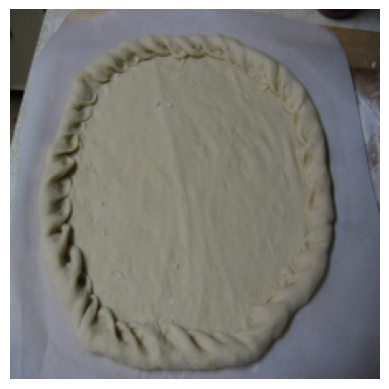

Ground Truth Captions: ['A crimped pie crust is on waxed paper.', 'pizza dough prepped and laid out on a table top ', 'The dough is shaped in a circle on the cloth.', 'a pizza shaped circle of round dough on a white surface', 'A pile of dough shaped into a pizza crust with twirls in it.']
Predicted Caption: A cheese pizza coming out of the oven.
BLEU Score: 0.5437246462410166
---
Average BLEU Score for k=5: 0.5444560367021352
---


In [152]:
import faiss
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets as dset
from PIL import Image
import random

def compute_query_vector(nearest_indices, caption_embeddings):
    selected_captions = caption_embeddings[nearest_indices.flatten()]
    query_vector = np.mean(selected_captions, axis=0)
    return query_vector

# Function for KNN captioning
def knn_captioning(image_embedding, caption_embeddings, k=5):
    flat_caption_embeddings = caption_embeddings.reshape(-1, 512)

    index = faiss.IndexFlatL2(flat_caption_embeddings.shape[1])
    if faiss.get_num_gpus() > 0:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)
    index.add(flat_caption_embeddings)

    _, nearest_indices = index.search(image_embedding, k)
    query_vector = compute_query_vector(nearest_indices, flat_caption_embeddings)
    closest_caption_index = np.argmin(np.linalg.norm(flat_caption_embeddings - query_vector, axis=1))

    return closest_caption_index

# Function to calculate BLEU score for a single prediction
def calculate_bleu_score(predicted_caption, ground_truth_captions):
    return sentence_bleu(ground_truth_captions, predicted_caption)

print('Number of samples: ', len(coco_dset))

# Shuffle indices for randomness
indices = list(range(len(image_embeddings)))
random.shuffle(indices)

# Experiment with different values of k
for k in [1, 3, 5]:
    total_accuracy = 0

    for i in indices[:5]:  # Visualize five images
        _, gt_captions = coco_dset[i]  # Retrieve ground truth captions here
        flat_index = knn_captioning(image_embeddings[i:i+1], caption_embeddings, k=k)

        image_index = flat_index // 5
        caption_index = flat_index % 5

        predicted_caption = coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(imgIds=coco_dset.ids[image_index]))[caption_index]['caption']
        bleu_score = calculate_bleu_score(predicted_caption, gt_captions)

        total_accuracy += bleu_score

        # Visualization
        img, _ = coco_dset[i]
        plt.imshow(transforms.ToPILImage()(img))
        plt.axis('off')
        plt.show()
        print(f'Ground Truth Captions: {gt_captions}')
        print(f'Predicted Caption: {predicted_caption}')
        print(f'BLEU Score: {bleu_score}')
        print('---')

    average_accuracy = total_accuracy / 5  # Average over the processed images
    print(f'Average BLEU Score for k={k}: {average_accuracy}')
    print('---')
